# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

In [1]:
import pandas as pd
import torch
import japanize_matplotlib
import numpy as np
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

c:\Users\uenoj\MyPython\deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### データセットの準備

In [2]:
ds = load_dataset("ylecun/mnist")

#### データセットの確認

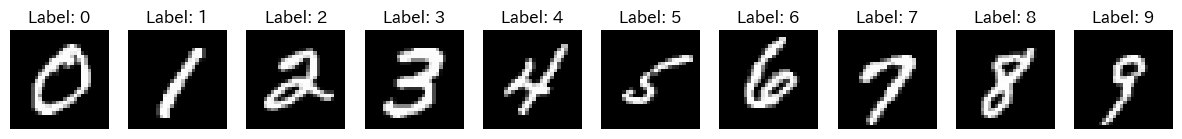

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
i, j, n = 0, 0, 0
while i < 10:
    label = ds['train'][n]['label']
    image = ds['train'][n]['image']
    n += 1
    if label == i:
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
        i += 1
plt.show()

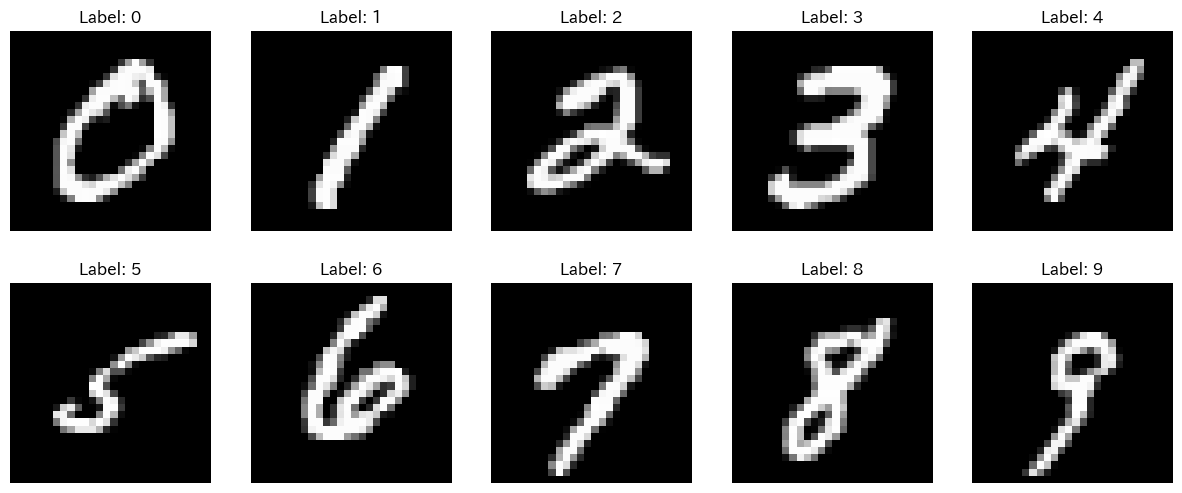

In [ ]:
# 0~9を確認
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
i, j, n = 0, 0, 0
while i < 10:
    label = ds['train'][n]['label']
    image = ds['train'][n]['image']
    n += 1
    if label == i:
        row, col = divmod(i, 5)
        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].set_title(f"Label: {label}")
        axes[row, col].axis('off')
        i += 1
plt.show()

In [5]:
train_size = len(ds['train'])
test_size = len(ds['test'])

print(f"訓練データの量: {train_size}")
print(f"テストデータの量: {test_size}")

訓練データの量: 60000
テストデータの量: 10000


In [6]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [7]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPUを使用します")
else:
    device = torch.device("cpu")
    print("CPUを使用します")
print(device)

GPUを使用します
cuda


In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


#### データサイズの移り変わりを確認
ダミーデータを使って、各層を順に通過させる

In [10]:
# ダミーデータを作成
dummy_input = torch.randn(1, 1, 28, 28).to(device)

# 各層の出力サイズを確認するために、モデルの各層を順に通過させる
x = dummy_input
print(f"入力サイズ: {x.size()}")

x = model.conv1(x)
print(f"conv1出力サイズ: {x.size()}")

x = model.pool(F.relu(x))
print(f"pool1出力サイズ: {x.size()}")

x = model.conv2(x)
print(f"conv2出力サイズ: {x.size()}")

x = model.pool(F.relu(x))
print(f"pool2出力サイズ: {x.size()}")

x = model.conv3(x)
print(f"conv3出力サイズ: {x.size()}")

x = model.pool(F.relu(x))
print(f"pool3出力サイズ: {x.size()}")

x = model.conv4(x)
print(f"conv4出力サイズ: {x.size()}")

x = model.pool(F.relu(x))
print(f"pool4出力サイズ: {x.size()}")

x = torch.flatten(x, 1)
print(f"フラット化後のサイズ: {x.size()}")

x = model.fc1(x)
print(f"fc1出力サイズ: {x.size()}")

x = model.fc2(x)
print(f"fc2出力サイズ: {x.size()}")

入力サイズ: torch.Size([1, 1, 28, 28])
conv1出力サイズ: torch.Size([1, 8, 28, 28])
pool1出力サイズ: torch.Size([1, 8, 14, 14])
conv2出力サイズ: torch.Size([1, 16, 14, 14])
pool2出力サイズ: torch.Size([1, 16, 7, 7])
conv3出力サイズ: torch.Size([1, 32, 7, 7])
pool3出力サイズ: torch.Size([1, 32, 3, 3])
conv4出力サイズ: torch.Size([1, 64, 3, 3])
pool4出力サイズ: torch.Size([1, 64, 1, 1])
フラット化後のサイズ: torch.Size([1, 64])
fc1出力サイズ: torch.Size([1, 32])
fc2出力サイズ: torch.Size([1, 10])


#### 損失関数とオプティマイザーを設定

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

損失関数には`CrossEntropyLoss`、オプティマイザーには`Adam`を利用。
学習率は0.001

#### モデルを訓練

In [12]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64)

エポック 1 
損失: 1.7351 
精度: 72.63%
---------------------------------------------
エポック 2 
損失: 1.6594 
精度: 79.86%
---------------------------------------------
エポック 3 
損失: 1.5799 
精度: 87.94%
---------------------------------------------
エポック 4 
損失: 1.4881 
精度: 97.32%
---------------------------------------------
エポック 5 
損失: 1.4849 
精度: 97.63%
---------------------------------------------
完了


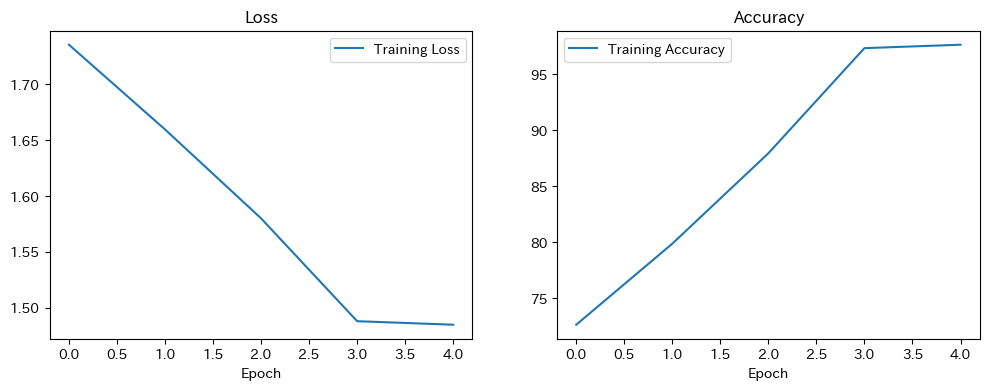

In [13]:
# モデルの訓練
model.train()
num_epochs = 5

# エポックごとの損失と精度を記録するリスト
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # エポックごとの損失と精度を計算
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # エポックごとの損失と精度を記録
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    print(f"エポック {epoch+1} \n損失: {epoch_loss:.4f} \n精度: {epoch_accuracy:.2f}%")
    print("---------------------------------------------")

print("完了")

# 損失と精度の推移をプロット (エポックごと)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Training Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Training Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')

plt.show()

#### 評価

In [14]:
# モデルを評価モードに設定
model.eval()
correct = 0

# データローダーを作成 (シャッフルなし)
test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=False)

# 予測とラベルを格納するリスト
predicts_list = []
labels_list = []
probs_list = []  # ROC曲線用の確率を格納

# 勾配計算を無効化
with torch.no_grad():
    for data in test_loader:
        # 画像とラベルを取得
        images, labels = data['image'], data['label']
        # 画像を適切な形状に変換し、デバイスに転送
        images = images.squeeze(2).float().to(device)
        labels = labels.to(device)

        # モデルに画像を入力して出力を取得
        outpts = model(images)
        # クラス1の確率を取得 (二値分類の場合)
        probs = outpts[:, 1]
        # 確率をリストに追加
        probs_list.extend(probs.cpu().numpy())

        # 予測結果を取得
        _, predicted = torch.max(outpts.data, 1)
        # 正答数を更新
        correct += (predicted == labels).sum().item()
        # 予測結果をNumPy配列に変換してリストに追加
        predicts_list.extend(predicted.cpu().numpy())
        # ラベルをNumPy配列に変換してリストに追加
        labels_list.extend(labels.cpu().numpy())

        # バッチごとの精度を出力 (監視用)
        print(f"バッチ精度: {100 * (predicted == labels).sum().item() / len(labels):.2f}%")
        print("-----------------------------------------------------------------")

print("完了")

バッチ精度: 95.31%
-----------------------------------------------------------------
バッチ精度: 98.44%
-----------------------------------------------------------------
バッチ精度: 95.31%
-----------------------------------------------------------------
バッチ精度: 96.88%
-----------------------------------------------------------------
バッチ精度: 96.88%
-----------------------------------------------------------------
バッチ精度: 100.00%
-----------------------------------------------------------------
バッチ精度: 98.44%
-----------------------------------------------------------------
バッチ精度: 95.31%
-----------------------------------------------------------------
バッチ精度: 93.75%
-----------------------------------------------------------------
バッチ精度: 93.75%
-----------------------------------------------------------------
バッチ精度: 98.44%
-----------------------------------------------------------------
バッチ精度: 100.00%
-----------------------------------------------------------------
バッチ精度: 96.88%
------------------------

##### ヒートマップでビジュアライズ


全体の精度: 96.0483%
全体の適合率: 96.6492%
全体の再現率: 96.0483%
全体のF1スコア: 96.1694%

分類レポート:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.98      0.99      0.99      6742
           2       0.98      0.97      0.98      5958
           3       1.00      0.90      0.95      6131
           4       0.98      0.98      0.98      5842
           5       0.77      1.00      0.87      5421
           6       0.98      0.95      0.97      5918
           7       0.99      0.95      0.97      6265
           8       0.98      0.95      0.97      5851
           9       0.99      0.92      0.96      5949

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.97      0.96      0.96     60000



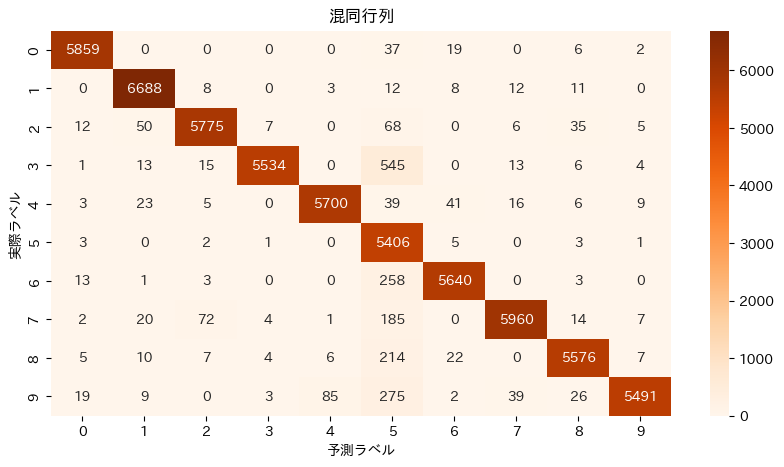

In [15]:
# 全体的な指標を計算して出力
accuracy = accuracy_score(labels_list, predicts_list)
precision = precision_score(labels_list, predicts_list, average='weighted')
recall = recall_score(labels_list, predicts_list, average='weighted')
f1 = f1_score(labels_list, predicts_list, average='weighted')

print(f"\n全体の精度: {accuracy * 100:.4f}%")
print(f"全体の適合率: {precision * 100:.4f}%")
print(f"全体の再現率: {recall * 100:.4f}%")
print(f"全体のF1スコア: {f1 * 100:.4f}%")

# 分類レポートを出力
print("\n分類レポート:")
print(classification_report(labels_list, predicts_list))

# 混同行列をプロット
cm = confusion_matrix(labels_list, predicts_list)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("混同行列")
plt.xlabel("予測ラベル")
plt.ylabel("実際ラベル")
plt.show()

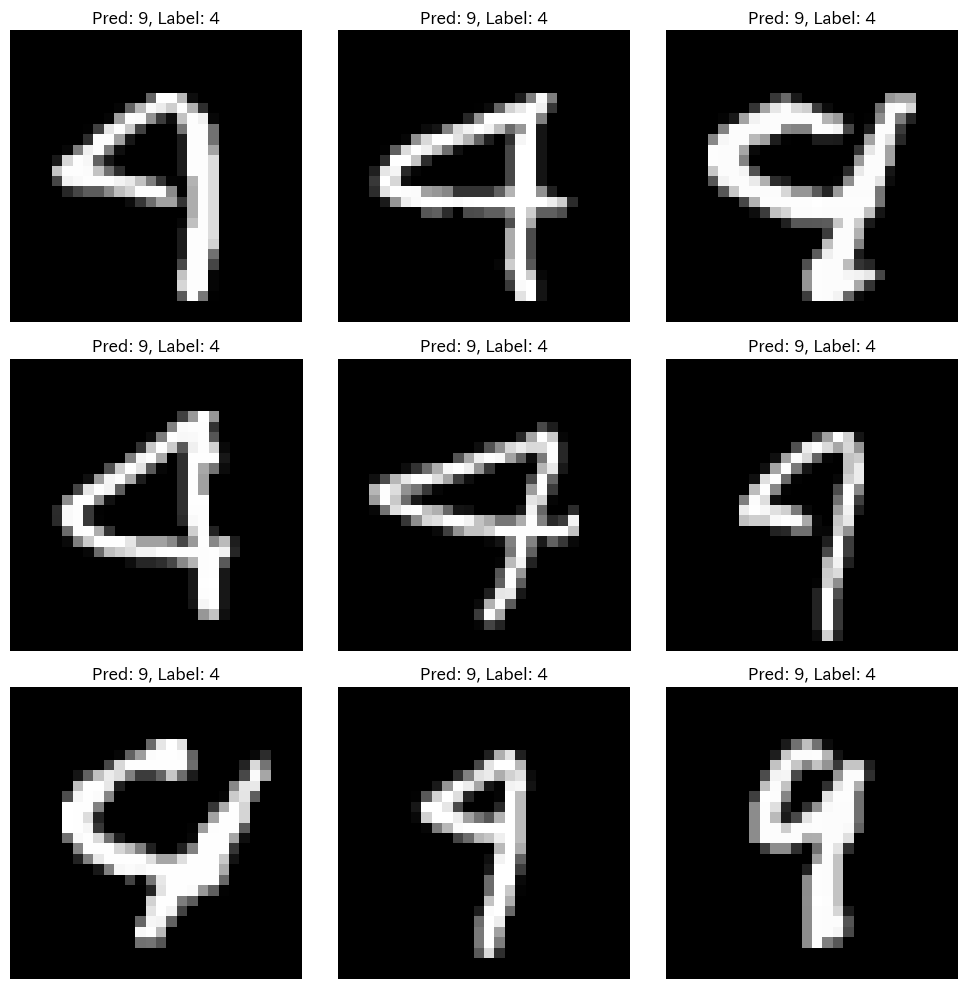

In [16]:
# 誤った予測をしているデータの画像を表示
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

# 誤った予測を抽出
incorrect_indices = [i for i, (pred, label) in enumerate(zip(predicts_list, labels_list)) if pred != label and pred == 9 and label == 4]

# 最初の9つの誤った予測を表示
for ax, idx in zip(axes, incorrect_indices[:9]):
    image = ds['train'][idx]['image']
    ax.imshow(image[0], cmap='gray')
    ax.set_title(f"Pred: {predicts_list[idx]}, Label: {labels_list[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# モデルの状態辞書を保存
torch.save(model.state_dict(), './streamlit-mnist-app/src/model/trained_mnist_cnn_model.pth')
print("モデルを保存しました")

モデルを保存しました


In [49]:
# モデルをロード
model.load_state_dict(torch.load('./streamlit-mnist-app/src/model/trained_mnist_cnn_model.pth'))

C:\Users\uenoj\AppData\Local\Temp\ipykernel_10164\4050255459.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./streamlit-mnist-app/src/

<All keys matched successfully>

エポック 1 
損失: 1.4847 
精度: 97.64%
検証データでの損失: 1.4795
検証データでの精度: 98.16%
---------------------------------------------
エポック 2 
損失: 1.4822 
精度: 97.88%
検証データでの損失: 1.4853
検証データでの精度: 97.57%
---------------------------------------------
エポック 3 
損失: 1.4849 
精度: 97.60%
検証データでの損失: 1.4903
検証データでの精度: 97.09%
---------------------------------------------
エポック 4 
損失: 1.4821 
精度: 97.90%
検証データでの損失: 1.4841
検証データでの精度: 97.70%
---------------------------------------------
エポック 5 
損失: 1.4831 
精度: 97.79%
検証データでの損失: 1.4810
検証データでの精度: 98.00%
---------------------------------------------


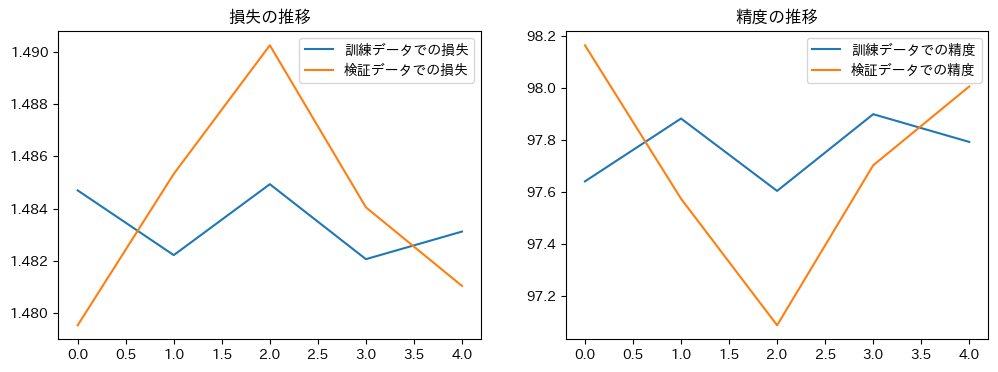

In [30]:
# トレーニングと検証の損失および精度を記録するリスト
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# モデルの訓練
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"エポック {epoch+1} \n損失: {train_loss:.4f} \n精度: {train_accuracy:.2f}%")

    # 検証データでの評価
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data['image'], data['label']
            inputs = inputs.squeeze(2).float().to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * val_correct / val_total)
    print(f"検証データでの損失: {val_loss / len(test_loader):.4f}")
    print(f"検証データでの精度: {100 * val_correct / val_total:.2f}%")
    print("---------------------------------------------")

    model.train()

# 学習曲線のプロット
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='訓練データでの損失')
plt.plot(val_losses, label='検証データでの損失')
plt.legend()
plt.title('損失の推移')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='訓練データでの精度')
plt.plot(val_accuracies, label='検証データでの精度')
plt.legend()
plt.title('精度の推移')

plt.show()